In [1]:
# import python packages
import shap
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import metrics, calibration
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.model_selection import GridSearchCV

In [2]:
# allow multiple outputs of a cell to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import os
os.chdir('/home/projects/aafek/nogal/noga_project/AI_hub/Repair-mutation project/Data')

In [4]:
# load data:
df_clean = pd.read_csv('mutations_TDG_genomic_processed.csv')
df_clean

,sequence_context,seqnames,start,PhyloP_score,is_CpG,experimental_ln_FI,label_counts,gene_type_TEC,gene_type_lncRNA,gene_type_miRNA,...,ccre_type_DNase-H3K4me3,"ccre_type_DNase-H3K4me3,CTCF-bound",ccre_type_PLS,"ccre_type_PLS,CTCF-bound",ccre_type_dELS,"ccre_type_dELS,CTCF-bound",ccre_type_pELS,"ccre_type_pELS,CTCF-bound",is_protein_coding,MAF_log
0,AACAAAA,1,99267131,-0.055,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-4.829928
1,AACAAAA,1,161294824,-1.399,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
2,AACAAAA,1,169903374,-1.708,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-7.825297
3,AACAAAA,1,82064640,-0.639,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
4,AACAAAA,1,153830104,-1.016,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-7.825297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,-0.868,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-3.874241
40666,TTCTTTT,1,26226773,-1.496,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-0.760356
40667,TTCTTTT,1,229773166,0.243,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
40668,TTCTTTT,1,106091814,-1.192,0,6.576470,10,False,True,False,...,False,False,False,False,False,False,False,False,1,-1.221119


### Relationship between PhyloP and TDG binding patterns

In [5]:
from scipy.stats import gaussian_kde
x = df_clean.PhyloP_score
y = df_clean.experimental_ln_FI
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

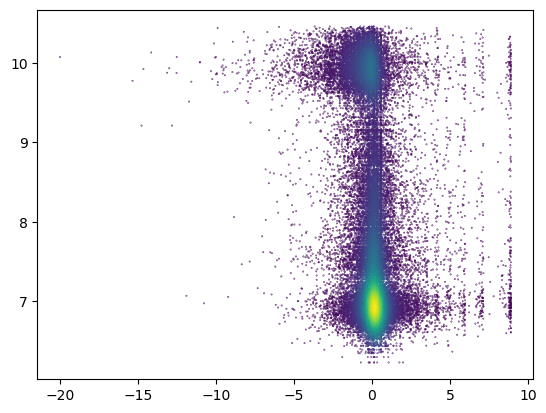

In [6]:
plt.scatter(x,y,c=z, s=0.1)

<Axes: xlabel='experimental_ln_FI', ylabel='Density'>

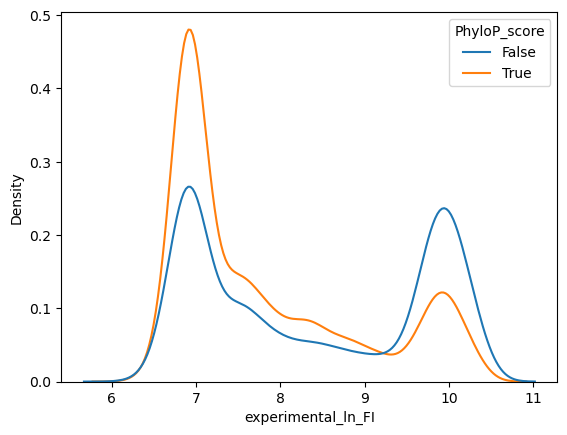

In [7]:
import seaborn as sns

sns.kdeplot(data=df_clean, x="experimental_ln_FI", hue=df_clean.PhyloP_score>0)


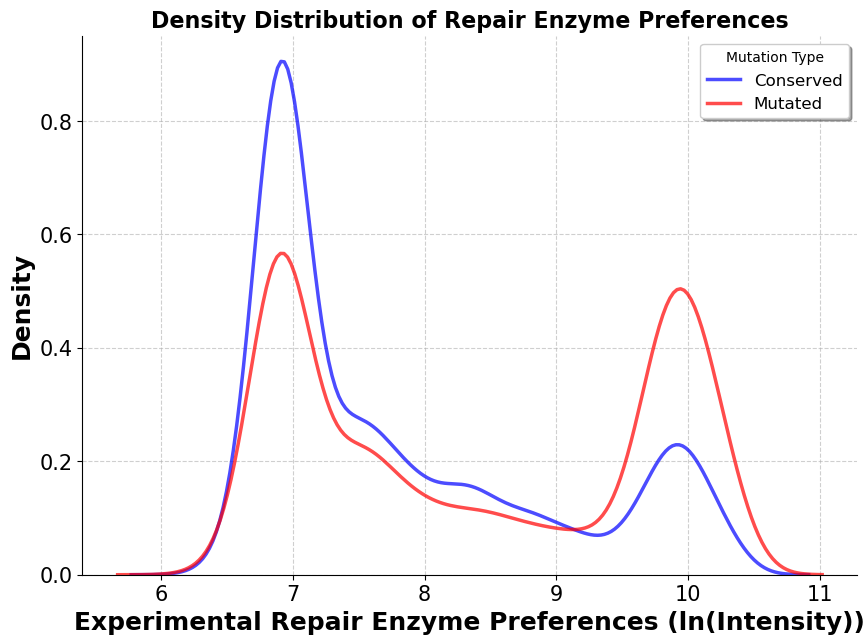

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors (similar to ROC curve)
custom_palette = {True: "blue", False: "red"}

# Create figure
plt.figure(figsize=(10, 7))

# KDE plot
sns.kdeplot(
    data=df_clean, 
    x="experimental_ln_FI", 
    hue=df_clean.PhyloP_score > 0, 
    fill=False,  # Make curves filled for better readability
    common_norm=False,  # Ensure each distribution is normalized independently
    palette=custom_palette,  # Apply custom colors
    linewidth=2.5,  # Match ROC curve line width
    alpha=0.7  # Adjust transparency
)

# Labels & Title (matching ROC plot)
plt.xlabel("Experimental Repair Enzyme Preferences (ln(Intensity))", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=18, fontweight="bold")
plt.title("Density Distribution of Repair Enzyme Preferences", fontsize=16, fontweight="bold")

# Customize ticks (matching ROC plot)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add grid with the same style as ROC plot
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend (matching ROC plot)
plt.legend(
    title="Mutation Type", 
    labels=["Conserved", "Mutated"], 
    fontsize=12, 
    frameon=True, 
    fancybox=True, 
    shadow=True, 
    loc="upper right", 
    #bbox_to_anchor=(1, 0.5)
)

# Remove unnecessary spines for a clean look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show plot
plt.show();

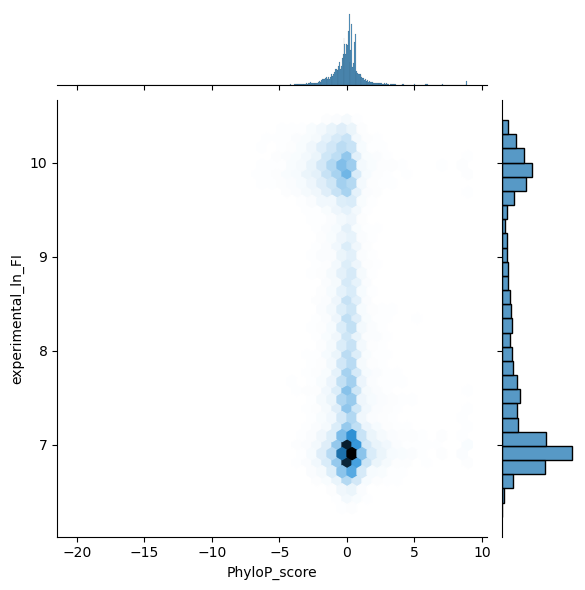

In [8]:
import seaborn as sns
sns.jointplot(data=df_clean, x="PhyloP_score", y="experimental_ln_FI", kind="hex");

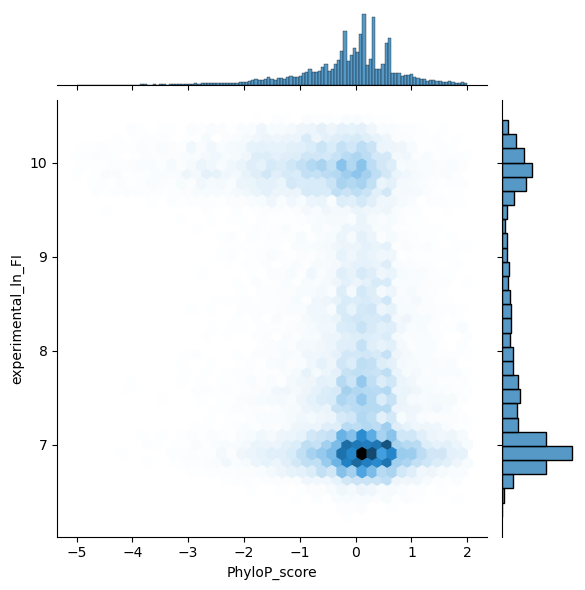

In [7]:
sns.jointplot(data=df_clean[(df_clean.PhyloP_score>-5) & (df_clean.PhyloP_score<2)], x="PhyloP_score", y="experimental_ln_FI", kind="hex");

### train a simplest classifier

In [36]:
# set threshold:
df_clean["bPhylop"] = df_clean.PhyloP_score > -2.5
df_clean["bExp"] = df_clean["experimental_ln_FI"] > 8.5

In [9]:
from collections import Counter
Counter(df_clean.bPhylop)

Counter({True: 38971, False: 1699})

In [10]:
Counter(df_clean.bExp)

Counter({False: 26730, True: 13940})

In [11]:
Counter(zip(df_clean.bPhylop, df_clean.bExp))

Counter({(True, False): 26297,
         (True, True): 12674,
         (False, True): 1266,
         (False, False): 433})

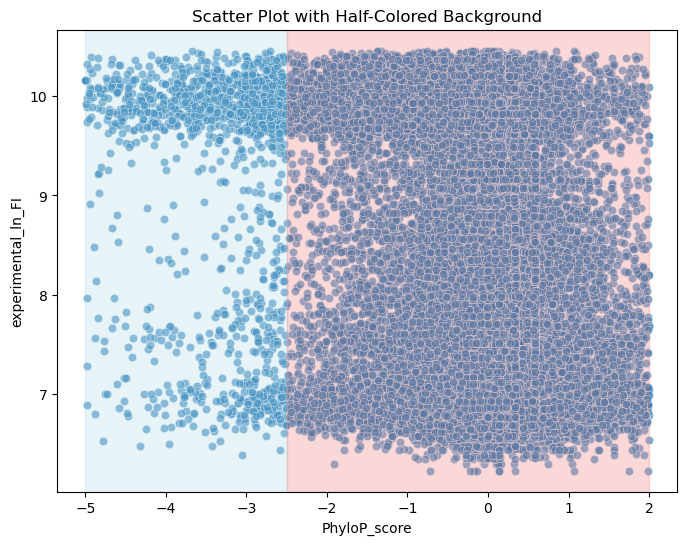

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtered Data
df_filtered = df_clean[(df_clean.PhyloP_score > -5) & (df_clean.PhyloP_score < 2)]

# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df_filtered, x="PhyloP_score", y="experimental_ln_FI", alpha=0.6)

# Get X-axis midpoint
mid_x = -2.5

# Add background color
plt.axvspan(df_filtered["PhyloP_score"].min(), mid_x, color="lightblue", alpha=0.3)  # Left half
plt.axvspan(mid_x, df_filtered["PhyloP_score"].max(), color="lightcoral", alpha=0.3)  # Right half

# Labels and title
plt.xlabel("PhyloP_score")
plt.ylabel("experimental_ln_FI")
plt.title("Scatter Plot with Half-Colored Background")

plt.show();

In [12]:
# Define features:
feature_names = ['is_CpG','is_protein_coding', 'experimental_ln_FI']
one_hot_feature_names = df_clean.columns[7:31].tolist()
all_features = feature_names + one_hot_feature_names  # Combine named & indexed features
all_features

['is_CpG',
 'is_protein_coding',
 'experimental_ln_FI',
 'gene_type_TEC',
 'gene_type_lncRNA',
 'gene_type_miRNA',
 'gene_type_misc_RNA',
 'gene_type_polymorphic_pseudogene',
 'gene_type_processed_pseudogene',
 'gene_type_protein_coding',
 'gene_type_rRNA_pseudogene',
 'gene_type_snRNA',
 'gene_type_snoRNA',
 'gene_type_transcribed_processed_pseudogene',
 'gene_type_transcribed_unitary_pseudogene',
 'gene_type_transcribed_unprocessed_pseudogene',
 'gene_type_unitary_pseudogene',
 'gene_type_unprocessed_pseudogene',
 'ccre_type_CTCF-only,CTCF-bound',
 'ccre_type_DNase-H3K4me3',
 'ccre_type_DNase-H3K4me3,CTCF-bound',
 'ccre_type_PLS',
 'ccre_type_PLS,CTCF-bound',
 'ccre_type_dELS',
 'ccre_type_dELS,CTCF-bound',
 'ccre_type_pELS',
 'ccre_type_pELS,CTCF-bound']

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import xgboost as xgb
from sklearn.metrics import classification_report

In [37]:
# Load data
df = df_clean.copy()

X = df[all_features]
y = df["bPhylop"].astype(int)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train XGBoost classifier
model = XGBClassifier(
    #use_label_encoder=False,
    eval_metric="logloss",  # Avoid warnings
    random_state=42,
    #tree_method="hist",     # Efficient for large datasets
    #enable_categorical=True, # Handles categorical features natively
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Adjust for imbalance
)

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

Confusion Matrix:
 [[ 210  130]
 [2040 5754]]

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.62      0.16       340
           1       0.98      0.74      0.84      7794

    accuracy                           0.73      8134
   macro avg       0.54      0.68      0.50      8134
weighted avg       0.94      0.73      0.81      8134



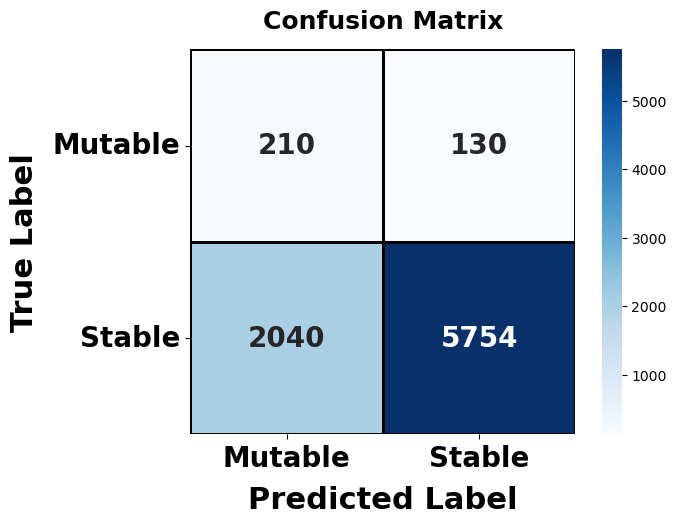

In [41]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))

# Create the heatmap with black borders
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=['Mutable', 'Stable'], 
                 yticklabels=['Mutable', 'Stable'],
                 linewidths=2, linecolor="black",  # Black borders
                 cbar=True, square=True, annot_kws={"size": 20, "weight": "bold"})

# Titles and labels with enhanced formatting
plt.title("Confusion Matrix", fontsize=18, fontweight="bold", pad=15)
plt.ylabel("True Label", fontsize=22, fontweight="bold", labelpad=10)
plt.xlabel("Predicted Label", fontsize=22, fontweight="bold", labelpad=10)

# Customize tick labels
plt.xticks(fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold", rotation=0)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show();

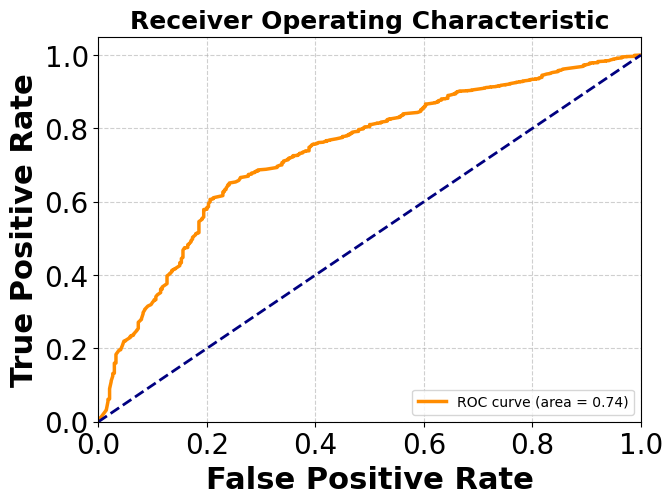

In [45]:
# 2. ROC Curve and AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Customize the axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

plt.xlabel('False Positive Rate',fontsize=22,fontweight="bold")
plt.ylabel('True Positive Rate',fontsize=22,fontweight="bold")
plt.title('Receiver Operating Characteristic',fontsize=18, fontweight="bold")
plt.legend(loc="lower right")
plt.show();



<Figure size 1000x700 with 0 Axes>

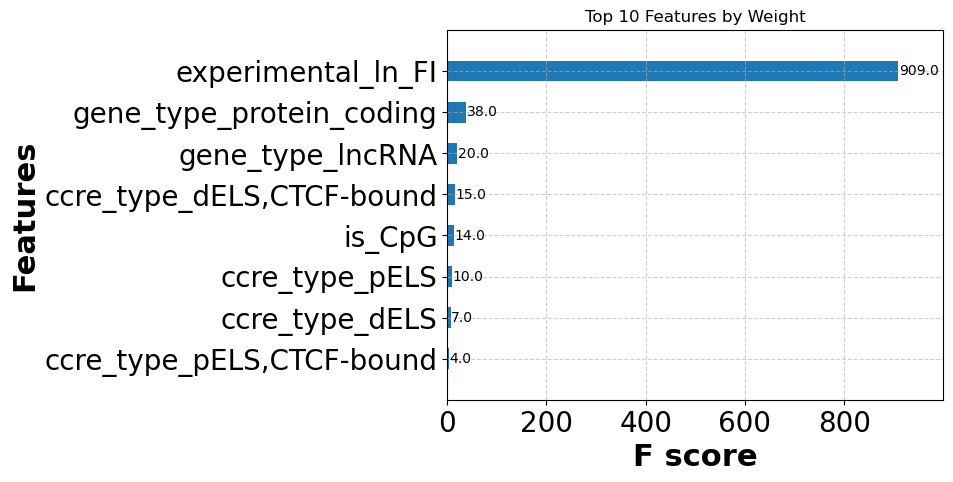

In [50]:
# 3. Feature Importance Plot
plt.figure(figsize=(10, 7))
xgb.plot_importance(model, importance_type="weight", max_num_features=10, height=0.5)
plt.title('Top 10 Features by Weight')
plt.xlabel("F score",fontsize=22,fontweight="bold")
plt.ylabel("Features",fontsize=22,fontweight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

plt.show();


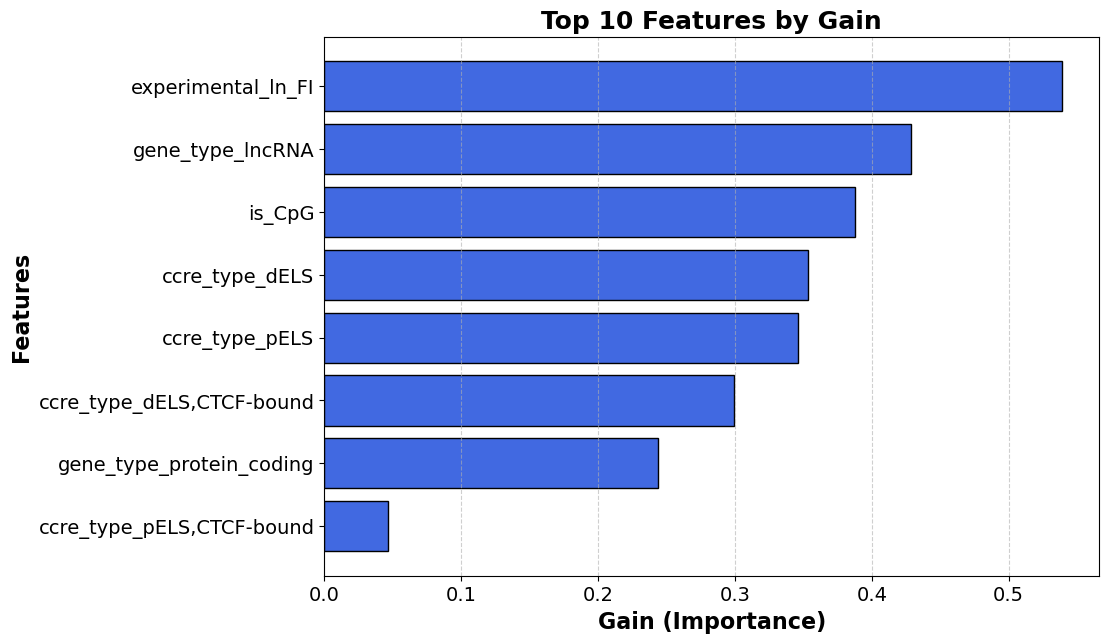

In [47]:
# Extract feature importance scores
importance = model.get_booster().get_score(importance_type="gain")
importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Gain"]).sort_values(by="Gain", ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 7))
plt.barh(importance_df["Feature"][:10], importance_df["Gain"][:10], color="royalblue", edgecolor="black")

# Add labels and title
plt.xlabel("Gain (Importance)", fontsize=16, fontweight="bold")
plt.ylabel("Features", fontsize=16, fontweight="bold")
plt.title("Top 10 Features by Gain", fontsize=18, fontweight="bold")

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Reverse y-axis for better readability
plt.gca().invert_yaxis()

# Add grid
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show();

### Different thresholds


Running classifier for threshold: -4.5

Running classifier for threshold: -4

Running classifier for threshold: -3

Running classifier for threshold: -2.5

Running classifier for threshold: -2

Running classifier for threshold: -1

Running classifier for threshold: 0

Running classifier for threshold: 1


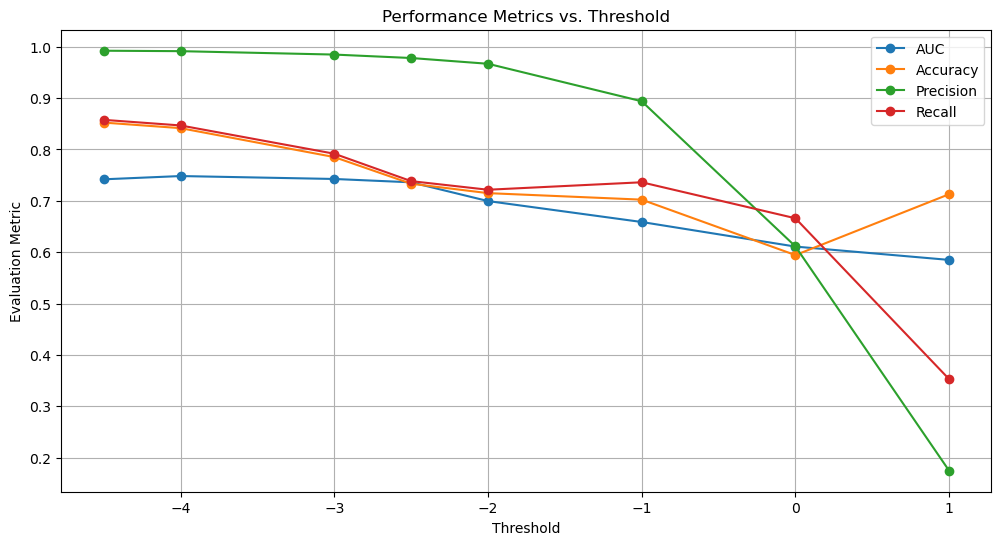

In [29]:
thresholds = [-4.5,-4,-3,-2.5,-2,-1, 0, 1]  # Define your thresholds
results = []  # To store evaluation metrics
roc_data = {}  # To store ROC curves for each threshold

for threshold in thresholds:
    print(f"\nRunning classifier for threshold: {threshold}")
    
    # Create binary labels
    df_clean['bPhylop'] = (df_clean['PhyloP_score'] >= threshold).astype(int)
    df = df_clean.dropna(subset=['PhyloP_score']).copy()

    X = df[all_features]
    y = df["bPhylop"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train XGBoost classifier
    model = XGBClassifier(
        #use_label_encoder=False,
        eval_metric="logloss",  # Avoid warnings
        random_state=42,
        #tree_method="hist",     # Efficient for large datasets
        #enable_categorical=True, # Handles categorical features natively
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Adjust for imbalance
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    results.append([threshold, roc_auc, accuracy, precision, recall])
    roc_data[threshold] = roc_curve(y_test, y_pred_prob)
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Threshold", "AUC", "Accuracy", "Precision", "Recall"])

In [30]:
results_df

,Threshold,AUC,Accuracy,Precision,Recall
0,-4.5,0.741802,0.852225,0.992098,0.857551
1,-4.0,0.748162,0.841406,0.991242,0.846653
2,-3.0,0.742465,0.785100,0.984608,0.791640
3,-2.5,0.735971,0.733219,0.977906,0.738260
4,-2.0,0.699464,0.714900,0.966702,0.721517
5,-1.0,0.658718,0.702238,0.893744,0.736033
6,0.0,0.610866,0.594296,0.611252,0.665978
7,1.0,0.584923,0.712810,0.174595,0.352825


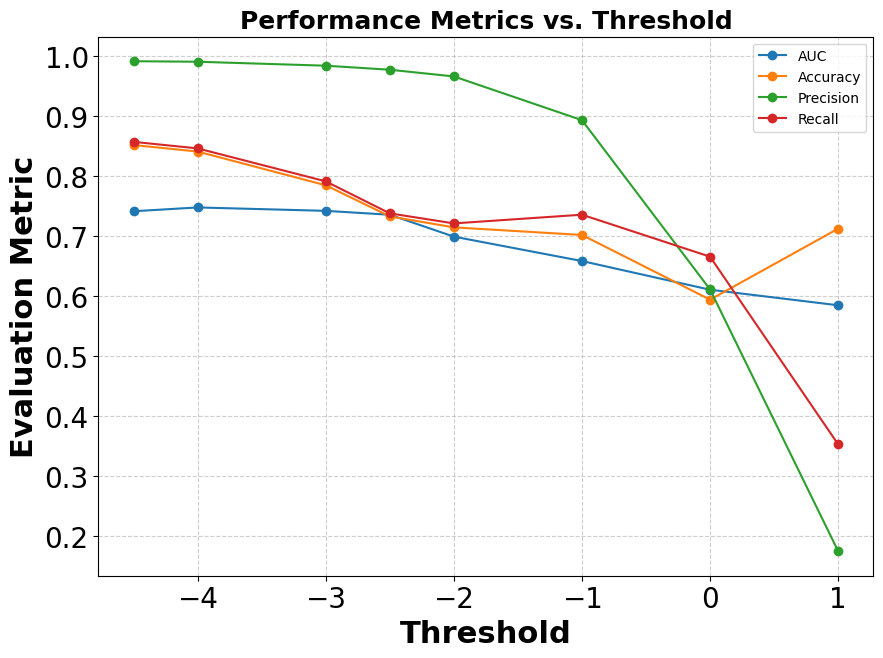

In [34]:
# Plot AUC, Accuracy, Precision, and Recall vs. Threshold
plt.figure(figsize=(10, 7))
plt.plot(results_df["Threshold"], results_df["AUC"], label="AUC", marker="o")
plt.plot(results_df["Threshold"], results_df["Accuracy"], label="Accuracy", marker="o")
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision", marker="o")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall", marker="o")
plt.xlabel("Threshold",fontsize=22,fontweight="bold")
plt.ylabel("Evaluation Metric",fontsize=22,fontweight="bold")
plt.title("Performance Metrics vs. Threshold",fontsize=18, fontweight="bold")

# Customize the axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

plt.legend()
plt.grid(True)
plt.show();

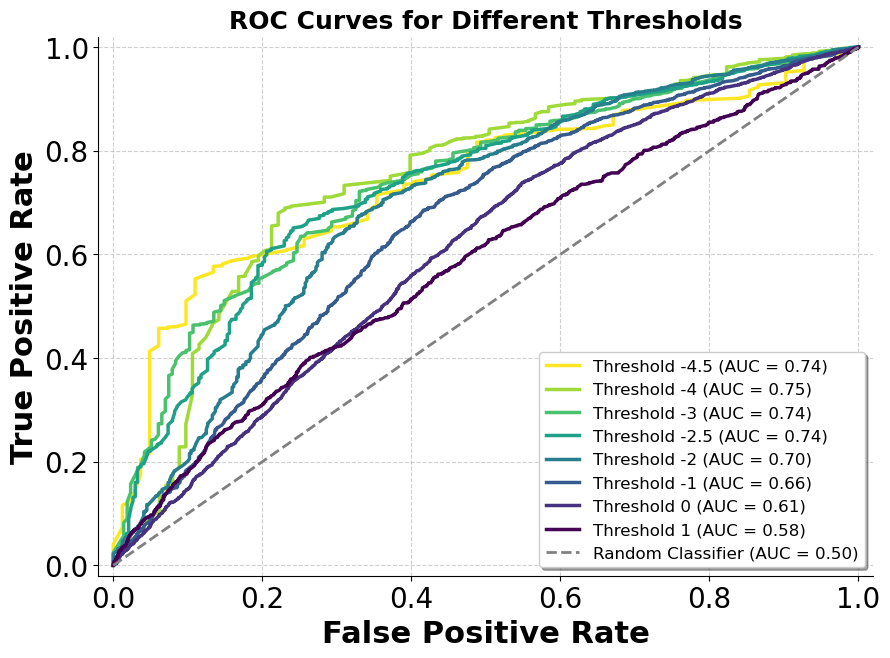

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.metrics import auc

# Define colormap
#colors = cm.viridis(np.linspace(0, 1, len(roc_data)))
colors = cm.viridis(np.linspace(1, 0, len(roc_data)))

# Create a figure
plt.figure(figsize=(10, 7))

# Plot each ROC curve with a unique color
for (threshold, (fpr, tpr, _)), color in zip(roc_data.items(), colors):
    plt.plot(fpr, tpr, lw=2.5, color=color, label=f"Threshold {threshold} (AUC = {auc(fpr, tpr):.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Classifier (AUC = 0.50)")

# Customize the axes
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Labels & title
plt.xlabel("False Positive Rate", fontsize=22, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=22, fontweight="bold")
plt.title("ROC Curves for Different Thresholds", fontsize=18, fontweight="bold")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend for better placement
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)

# Remove unnecessary spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the final plot
plt.show();